# Forest Cover Prediction

- **Class Section: 2019 Summer - Monday 6:30 PM**

- **Project Team: Adam Sohn, Curtis Lin, Erik Hou, Youzhi (Chloe) Wu**


=====================================================================================================================

## 1. Problem Description & Objectives

The objective of this project is to use a machine learning algorithm to predict the forest canopy cover type by using cartographic variables only. The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. 

=====================================================================================================================

## 2. Dataset Description

The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. The dataset describes 30x30 meter cells in four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The dataset contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.
The dataset also contains continuous, unscaled, quantitative data to describe independant variables such as elevation and distance from roads.

Dataset: https://www.kaggle.com/c/forest-cover-type-prediction

=====================================================================================================================

## 3. Project Plan

1. Perform EDA to explore data, noting irregularities and relationships between variables.
2. Pilot study several applicable classification algorithms to hone in on most promising algorithm(s).
3. Apply feature engineering to improve classifier performance: potential algorithms for feature engineering may include
    - Decision tree
    - PCA
    - Random forest regressor
    - Use domain knowledge to featurize soil types
4. Optimize promising algorithm(s) with bagging, ensemble and cross validations
5. Summarize findings.

=====================================================================================================================

## Package Loading

In [2]:
%matplotlib inline

# General libraries
import csv
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from collections import defaultdict
from numpy import genfromtxt

# SK-learn libraries for learning.
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# SK-learn model packages 
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import BaggingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

import pandas as pd
pd.set_option('display.max_columns', None)

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

## Data Loading


Below are 3 different data loaders to compliment different coding methodologies. Methodologies will be condensed to a single loader in future revision.

<font color=red>**Updated since baseline: data_to_np function is updated** 
    **(1) To only avoid getting headers, it will not avoid getting the first column of the dataframe**
    **(2) Add astype('int') to the end to ensure that train_labels, dev_labels and test_labels dtype is int.**</font>

In [78]:
### Pandas dataframe for EDA, feature engineering

train_raw_df = pd.read_csv("./forest-cover-type-prediction/train.csv")
train_df = train_raw_df.loc[:,"Elevation":] #remove ID column from df
test_df_no_label = pd.read_csv('./forest-cover-type-prediction/test.csv') # this dataframe is for final prediction


### Call this function after feature engineering on pandas dataframe to generate numpy array
def data_to_np(my_data=train_raw_df.values):
    '''Takes numpy array as argument in order to return train/dev/test datasets 
    according to desired feature engineering. Default is no feature engineering.'''
    np.random.seed(0)
    data = my_data[1:, :my_data.shape[1]-1]  # avoid getting headers 
    labels = my_data[1:,-1]
    
    shuffle = np.random.permutation(np.arange(data.shape[0]))

    shuffled_data = data[shuffle]
    shuffled_labels = labels[shuffle]
    shuffled_labels = shuffled_labels - 1

    # split the data to 60% train, 20% dev and 20% test
    num_train = int(shuffled_data.shape[0]*0.6)
    num_dev = int(shuffled_data.shape[0]*0.8)

    train_data, train_labels = shuffled_data[:num_train], shuffled_labels[:num_train]
    dev_data, dev_labels = shuffled_data[num_train:num_dev], shuffled_labels[num_train:num_dev]
    test_data, test_labels = shuffled_data[num_dev:], shuffled_labels[num_dev:]
    train_labels = train_labels.astype('int')
    dev_labels = dev_labels.astype('int')
    test_labels = test_labels.astype('int')

#     data = train.loc[:,train.columns != 'Cover_Type'].values
#     labels = train[['Cover_Type']].values.flatten()
#     train_data, dev_data, train_labels, dev_labels = train_test_split(data, labels, test_size=0.3, random_state=0)
    return train_data, dev_data, test_data, train_labels, dev_labels, test_labels

=====================================================================================================================

## EDA

### *Chloe*

In [50]:
print("Test data shape:",test_df_no_label.shape)
print(test_df_no_label.columns)

Test data shape: (565892, 55)
Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_

> Test_df from test.csv does not have cover_type column. It is intended for prediction only. As such, we will need to subset train_df to train and dev datasets for our modeling process. 

In [51]:
print(train_df.describe())

          Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%            

In [52]:
# Count the number of instances of each class
print(train_df.groupby('Cover_Type').size())

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64


> The cover types are equally divided into 7 categories in our training csv. So there is no skewness in our dataset. 

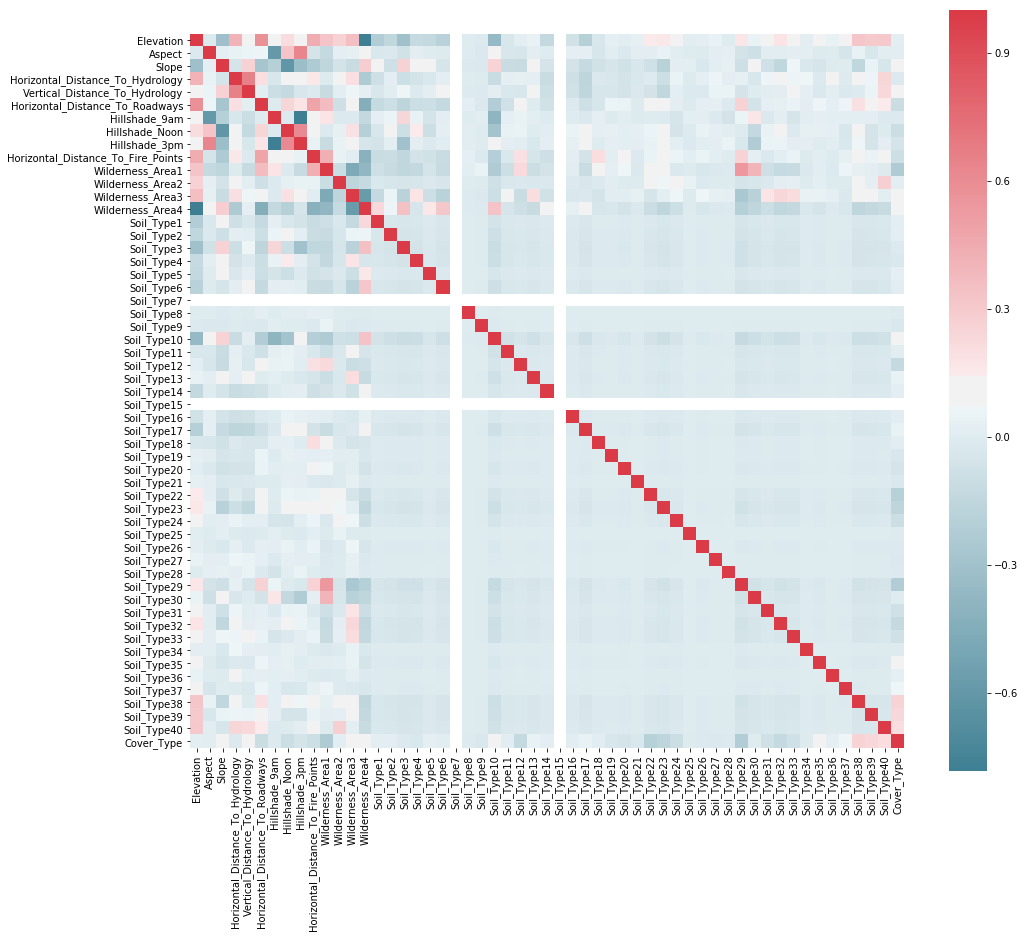

In [53]:
# Plot correlation heatmap to find highly correlated variables /features
corr = train_df.corr()

f, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

> From above heat map, the following variables are considered relatively high correlated with cover type:
- Horizontal_Distance_To_Roadways
- Horizontal_Distance_To_Fire_Points
- Hillshade_Noon
- Wilderness_Area1
- Soil_Type12, Soil_Type22, Soil_Type23, Soil_Type29, Soil_Type32, Soil_Type38, Soil_Type39, Soil_Type40

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


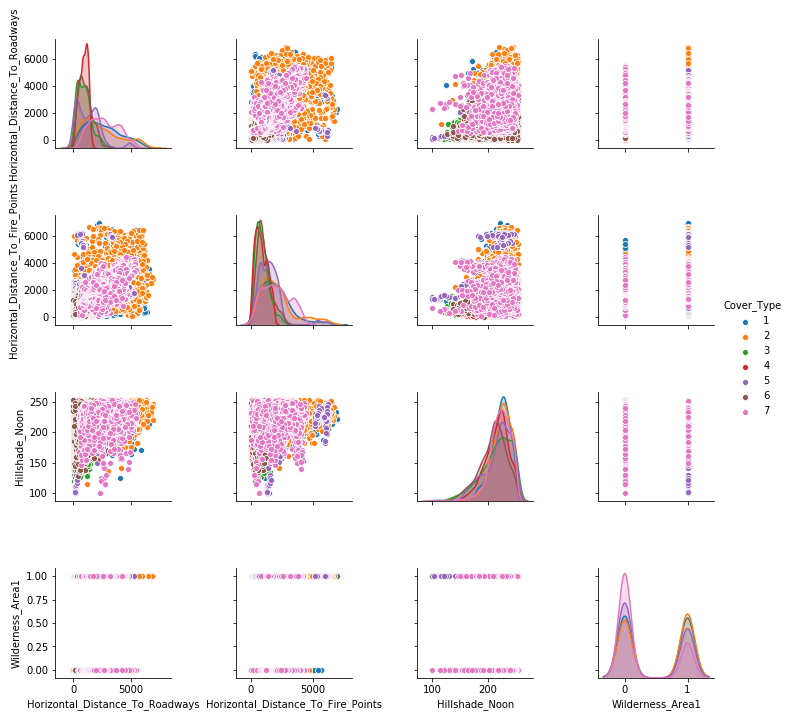

In [54]:
# Variables that are relatively high correlated with cover type are selected here
sns.pairplot(train_df, hue='Cover_Type', vars=["Horizontal_Distance_To_Roadways",
                                               "Horizontal_Distance_To_Fire_Points", 
                                               "Hillshade_Noon","Wilderness_Area1"])

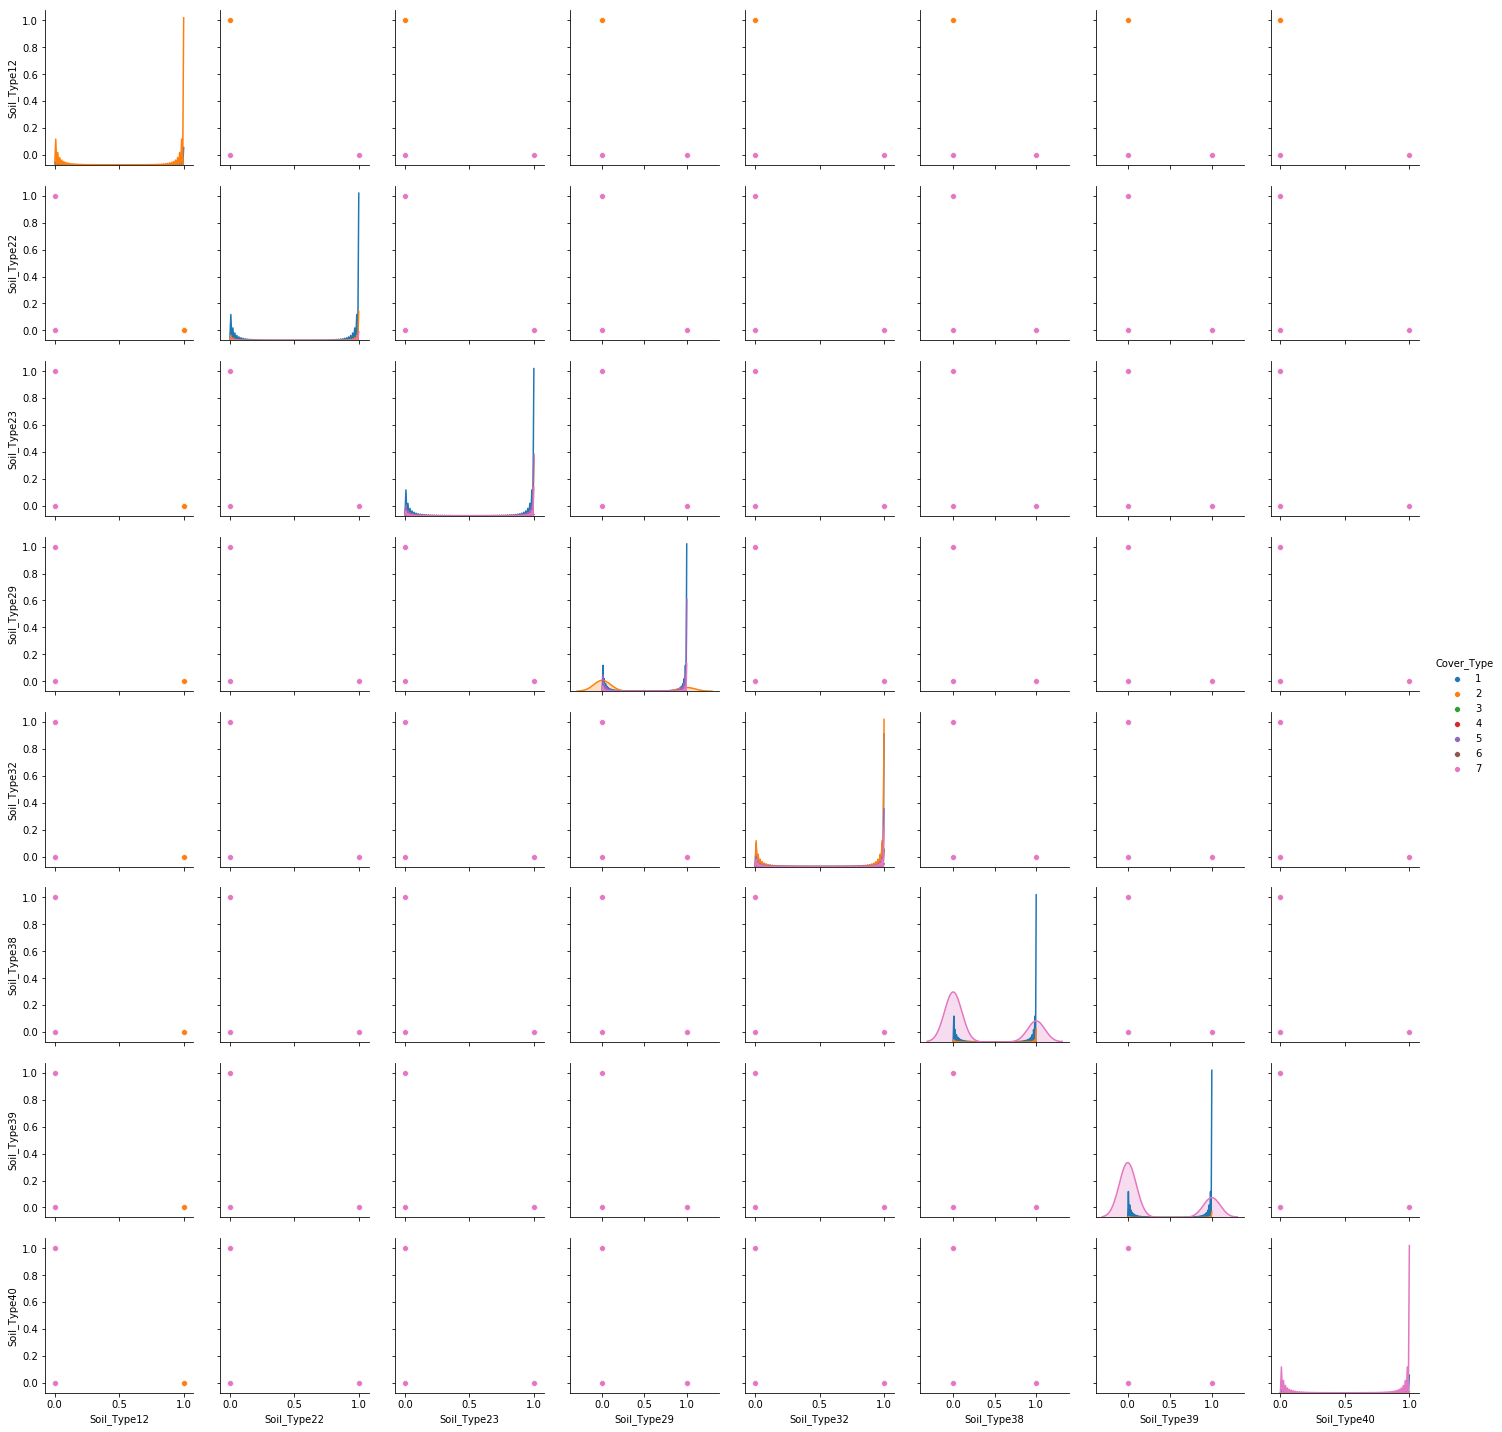

In [55]:
# Variables that are relatively high correlated with cover type are selected here
sns.pairplot(train_df, hue='Cover_Type', vars=["Soil_Type12","Soil_Type22",
                                               "Soil_Type23","Soil_Type29",
                                               "Soil_Type32","Soil_Type38",
                                               "Soil_Type39","Soil_Type40"])

### *Erik*

In [ ]:
# print(train_data.shape)
# print(train_labels.shape)

In [ ]:
def generate_cor_graph(data, size=(15,15), title = None):
    
    corr = data.corr()
    fig = plt.figure(figsize = size)
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.tight_layout()
    plt.title(title, y=1.2)
    plt.show()

In [ ]:
# df = pd.read_csv('forest-cover-type-prediction/train.csv')

In [ ]:
# Curtis: change df to train_df

generate_cor_graph(train_df)

In [ ]:
# Curtis: change df to train_df; change range(1,15) to range(0,14)

cols = [i for i in range(0,14)]
cols = [-1] + cols
data_soil_id_exclu = train_df.iloc[:,cols]
generate_cor_graph(data_soil_id_exclu, (10,10))

In [ ]:
data_soil_id_exclu.describe()

In [ ]:
train_df.iloc[:, 14:].describe()

In [ ]:
cover_types = np.sort(train_df.iloc[:, -1].unique())
df_dict = {}

for cover_type in cover_types:
    df_dict[cover_type] = train_df.loc[train_df['Cover_Type'] == cover_type]

for cover_type in cover_types:
    generate_cor_graph(data = df_dict[cover_type], title = 'Cover Type' + str(cover_type))

### *Curtis*

In [ ]:
# Geographic information

train_df.iloc[:,0:3].describe() 

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
geograpy = ['Elevation', 'Aspect', 'Slope']

for i in range(0, 3):
    ax[i-1].hist(train_df.loc[:,geograpy[i]])
    ax[i-1].set_title(geograpy[i-1])   

In [ ]:
# Hydrological information

train_df.iloc[:,3:5].describe()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
hydrology = ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']

for i in range(2):
    ax[i].hist(train_df.loc[:,hydrology[i]])
    ax[i].set_title(hydrology[i])

In [ ]:
# Distance to roadways and fire points

train_df.loc[:,['Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']].describe()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))


ax[0].hist(train_df.loc[:,'Horizontal_Distance_To_Roadways'])
ax[0].set_title('Horizontal_Distance_To_Roadways')
ax[1].hist(train_df.loc[:,'Horizontal_Distance_To_Fire_Points'])
ax[1].set_title('Horizontal_Distance_To_Fire_Points')

In [ ]:
# Hillshade information (0 to 255 index) 

train_df.iloc[:,6:9].describe()

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20, 4))
hillshade = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

for i in range(3):
    ax[i].hist(train_df.loc[:,hillshade[i]])
    ax[i].set_title(hillshade[i])
    
ax[3].scatter(train_df.loc[:,'Hillshade_9am'], train_df.loc[:,'Hillshade_Noon'])
ax[3].set_title("9am vs Noon")
ax[4].scatter(train_df.loc[:,'Hillshade_9am'], train_df.loc[:,'Hillshade_3pm'])
ax[4].set_title("9am vs 3pm")
ax[5].scatter(train_df.loc[:,'Hillshade_Noon'], train_df.loc[:,'Hillshade_3pm'])
ax[5].set_title("Noon vs 3pm")

In [ ]:
# Wilderness area information

train_df.iloc[:,10:14].describe()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
wilderness = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre']

for i in range(4):
    ax[i].hist(train_df.iloc[:,i+10])
    ax[i].set_title(wilderness[i])

In [ ]:
# Soil information (binary data)

train_df.iloc[:,14:54].describe()

1 Cathedral family - Rock outcrop complex, extremely stony.

2 Vanet - Ratake families complex, very stony.

3 Haploborolis - Rock outcrop complex, rubbly.

4 Ratake family - Rock outcrop complex, rubbly.

5 Vanet family - Rock outcrop complex complex, rubbly.

6 Vanet - Wetmore families - Rock outcrop complex, stony.

7 Gothic family.

8 Supervisor - Limber families complex.

9 Troutville family, very stony.

10 Bullwark - Catamount families - Rock outcrop complex, rubbly.

11 Bullwark - Catamount families - Rock land complex, rubbly.

12 Legault family - Rock land complex, stony.

13 Catamount family - Rock land - Bullwark family complex, rubbly.

14 Pachic Argiborolis - Aquolis complex.

15 unspecified in the USFS Soil and ELU Survey.

16 Cryaquolis - Cryoborolis complex.

17 Gateview family - Cryaquolis complex.

18 Rogert family, very stony.

19 Typic Cryaquolis - Borohemists complex.

20 Typic Cryaquepts - Typic Cryaquolls complex.

21 Typic Cryaquolls - Leighcan family, till substratum complex.

22 Leighcan family, till substratum, extremely bouldery.

23 Leighcan family, till substratum - Typic Cryaquolls complex.
24 Leighcan family, extremely stony.

25 Leighcan family, warm, extremely stony.

26 Granile - Catamount families complex, very stony.

27 Leighcan family, warm - Rock outcrop complex, extremely stony.

28 Leighcan family - Rock outcrop complex, extremely stony.

29 Como - Legault families complex, extremely stony.

30 Como family - Rock land - Legault family complex, extremely stony.

31 Leighcan - Catamount families complex, extremely stony.

32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.

33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.

34 Cryorthents - Rock land complex, extremely stony.

35 Cryumbrepts - Rock outcrop - Cryaquepts complex.

36 Bross family - Rock land - Cryumbrepts complex, extremely stony.

37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.

38 Leighcan - Moran families - Cryaquolls complex, extremely stony.

39 Moran family - Cryorthents - Leighcan family complex, extremely stony.

40 Moran family - Cryorthents - Rock land complex, extremely stony.

=====================================================================================================================

## 4. Feature Engineering

### Feature information

Elevation - Elevation in meters

Aspect - Aspect in degrees azimuth

Slope - Slope in degrees

Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features

Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features

Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway

Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice

Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice

Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice

Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points

Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation

Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

### *Adam*

In [ ]:
soil_feature = pd.read_csv("./forest-cover-type-prediction/soil_feature.csv")
print(soil_feature.head())

#### Feature Engineering Round 1 (Soil_Type15 , Id)
'Soil_Type15' is 'unspecified in the USFS Soil and ELU Survey.' This is not a distinct category and therefore does not aid classification. <br>
'Id' is not a feature, but rather acts to remove randomization, which is undesired.<br>

* Eliminate any row containing 'Soil_Type15'. Eliminate column for 'Soil_Type15'.
* Eliminate column for 'Id'

In [ ]:
# Curtis: change train_df1 = train_df.drop(columns = ['Id', 'Soil_Type15']) to 
# train_df1 = train_raw_df.drop(columns = [Soil_Type15'])

# train_df1 = train_df[train_df['Soil_Type15'] == 0]
# test_df1 = train_df[test_df['Soil_Type15'] == 0]

train_df1 = train_raw_df.drop(columns = ['Soil_Type15'])
# test_df1 = test_df.drop(columns = ['Id', 'Soil_Type15'])

#### Feature Engineering Round 2 (Soil_Type to features, keep Soil_Type)
Description of Soil Types yields commonalities which expands a sample's feature set.

* Create single column in train_df & test_df for 'Soil_Type' to match soil_feature featurizer table.
* Merge train_df and test_df on soil_feature featurizer table 'Soil_Type' column
* Eliminate Soil_Type columns. 
* Inclusive of Round1

In [ ]:
# Curtis: add 'Id'

#Import data of featurizer table
soil_feature = pd.read_csv('./forest-cover-type-prediction/soil_feature.csv')

#Establish dataframes as deep copies
train_df2 = train_df1.copy(deep= True)
# test_df2 = test_df1.copy(deep= True)

#Aggregating soil types in train_df2 and test_df2 for use as merge index
soil_cols = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40']
train_df2['Soil_Type'] = train_df2[soil_cols].idxmax(axis=1)
# test_df2['Soil_Type'] = test_df2[soil_cols].idxmax(axis=1)

#Merging train_df2 and test_df2 with soil_feature
train_df2 = train_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')
# test_df2 = test_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')

#Manually reordering columns on train_df2 to make 'Cover_Type' at the end of the list.  
#Note this is not necessary for test2_df due to absence of 'Cover_Type' column. 
#Also eliminating 'Soil_Type' columns.
reordered_cols = ['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Rock outcrop', 'Rock Land',
#        'Complex',
        'Stony', 'Rubbly', 'Cyraquolls', 'Cryumbrepts',
       'Cryorthents', 'Leighcan', 'Till substratum', 'Catmount', 'Legault',
       'Moran', 'Bullwark', 'Crayaquepts', 'Vanet', 'Como', 'Cover_Type']
train_df2 = train_df2[reordered_cols]

#### Feature Engineering Round 3 (Feature Reduction)
Reducing features to only those w/ random forest scoring > 0.1
* Inclusive of Round2

In [ ]:
#Establish dataframes as deep copies
train_df3 = train_df2.copy(deep= True)
# test_df3 = test_df2.copy(deep= True)

train_df3 = train_df3.reset_index(drop=True)

print(train_df3.columns)
print(train_df3['Cover_Type'].head(9))

train_keys = ['Elevation', 'Moran', 'Horizontal_Distance_To_Roadways', 'Cover_Type']
test_keys = ['Elevation', 'Moran', 'Horizontal_Distance_To_Roadways']

train_df3 = train_df3[train_keys]
# test_df3 = test_df3[test_keys]

### *Curtis*

In [30]:
# Curtis

train_raw_df_ID = train_raw_df.iloc[:,0]
train_raw_df_cont = train_raw_df.iloc[:,1:11]
train_raw_df_disc = train_raw_df.iloc[:,11:55]
train_raw_df_cover = train_raw_df.iloc[:,55]

In [31]:
# normalize continuous variables of training data 
train_raw_df_cont_norm = preprocessing.normalize(train_raw_df_cont)
train_raw_df_cont_norm = pd.DataFrame(train_raw_df_cont_norm)
train_raw_df_cont_norm.columns = train_raw_df_cont.columns.values
train_raw_df_cont_norm.index = train_raw_df_cont.index.values
# train_raw_df_cont_norm.head()

In [32]:
# combine normalized continuous variable and binary variable of training data 
train_raw_df_norm = pd.concat([train_raw_df_ID, train_raw_df_cont_norm, train_raw_df_disc, train_raw_df_cover], 
                              axis = 1)
train_raw_df_norm.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,0.380210,0.007469,0.000439,0.037787,0.000000,0.074695,0.032368,0.033979,0.021676,0.919622,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,0.382769,0.008276,0.000296,0.031331,-0.000887,0.057637,0.032513,0.034730,0.022316,0.919975,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,0.375821,0.018630,0.001206,0.035920,0.008712,0.426216,0.031363,0.031899,0.018094,0.820399,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,0.371810,0.020693,0.002403,0.032308,0.015754,0.412529,0.031774,0.031774,0.016288,0.829196,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,0.386275,0.006698,0.000298,0.022775,-0.000149,0.058202,0.032748,0.034832,0.022328,0.918725,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


> using PCA to reduce soil features

### <font color = red> *Chloe* - Updated since baseline </font>
#### <font color = red> Feature Engineering - Round 1 by Chloe</font>
- <font color = red>Feature engineering: categorize aspect and elevation</font>
- <font color = red>Re-run algo --> See **minor improvement** in accuracy</font>

In [4]:
# add by Curtis

train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np()

In [5]:
# Rank feature importance based off Random Forest Regressor results
names = train_df.columns.values
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.4089, 'Elevation'), (0.0858, 'Horizontal_Distance_To_Fire_Points'), (0.0783, 'Horizontal_Distance_To_Roadways'), (0.0421, 'Horizontal_Distance_To_Hydrology'), (0.0368, 'Hillshade_3pm'), (0.0362, 'Soil_Type39'), (0.0361, 'Aspect'), (0.0356, 'Vertical_Distance_To_Hydrology'), (0.0316, 'Hillshade_9am'), (0.0302, 'Slope'), (0.0297, 'Hillshade_Noon'), (0.0247, 'Soil_Type38'), (0.0164, 'Soil_Type12'), (0.0141, 'Soil_Type32'), (0.0096, 'Wilderness_Area3'), (0.0096, 'Soil_Type35'), (0.009, 'Soil_Type29'), (0.0089, 'Soil_Type10'), (0.008, 'Wilderness_Area1'), (0.0068, 'Soil_Type22'), (0.0043, 'Soil_Type30'), (0.0037, 'Soil_Type4'), (0.0036, 'Soil_Type13'), (0.0034, 'Soil_Type40'), (0.003, 'Soil_Type33'), (0.003, 'Soil_Type24'), (0.0029, 'Soil_Type23'), (0.0026, 'Soil_Type31'), (0.0024, 'Soil_Type20'), (0.0021, 'Soil_Type17'), (0.0018, 'Soil_Type2'), (0.0015, 'Soil_Type3'), (0.0014, 'Wilderness_Area4'), (0.0012, 'Wilderness_Area2'), (0.001, 'Soil_Type11'), (0.

In [37]:
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:54]
train_df_cover = train_df.iloc[:,54]

train_df_cont = pd.concat([train_df_cont_noLabel, train_df_cover], axis = 1)
train_df_disc = pd.concat([train_df_disc_noLabel, train_df_cover], axis = 1)

display(train_df_cont.head())
display(train_df_disc.head())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,5
1,2590,56,2,212,-6,390,220,235,151,6225,5
2,2804,139,9,268,65,3180,234,238,135,6121,2
3,2785,155,18,242,118,3090,238,238,122,6211,2
4,2595,45,2,153,-1,391,220,234,150,6172,5


,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


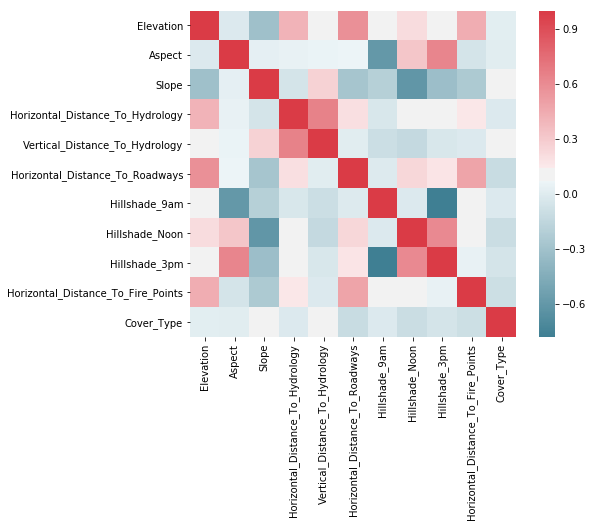

In [7]:
# Plot correlation heatmap among continuous variables with to find highly correlated variables /features
corr_cont = train_df_cont.corr()

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_cont, mask=np.zeros_like(corr_cont, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

> From the correlation heatmap we can see that 
- **Elevation** is highly correlated with several other variables, such as:
    - Horizontal_Distance_To_Hydrology
    - Horizontal_Distance_To_Roadways
    - Hillshade_Noon
    - Horizontal_Distance_To_Fire_Points
- **Aspect** is highly correlated with the following variables:
    - Hillshade_9am
    - Hillshade_Noon
    - Hillshade_3pm
- **Slope** is highly correlated with the following variables:
    - Hillshade_Noon
- **Horizontal_Distance_To_Hydrology** is highly correlated with the following variables:
    - Vertical_Distance_To_Hydrology
- **Horizontal_Distance_To_Roadways** is highly correlated with the following variables:
    - Horizontal_Distance_To_Fire_Points
- **Hillshade_9am** is highly negatively correlated with the following variables:
    - Hillshade_3pm
- **Hillshade_Noon** is highly positively correlated with the following variables:
    - Hillshade_3pm

> Hillshade is a function of : $Hillshade = 255.0 * \left[ \cos \left[(90 - Altitude)\frac{\pi}{180}\right] \cos(Slope) + \sin\left[(90 - Altitude)\frac{\pi}{180}\right] \sin(Slope) \cos(Azimuth - Aspect) \right]$

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


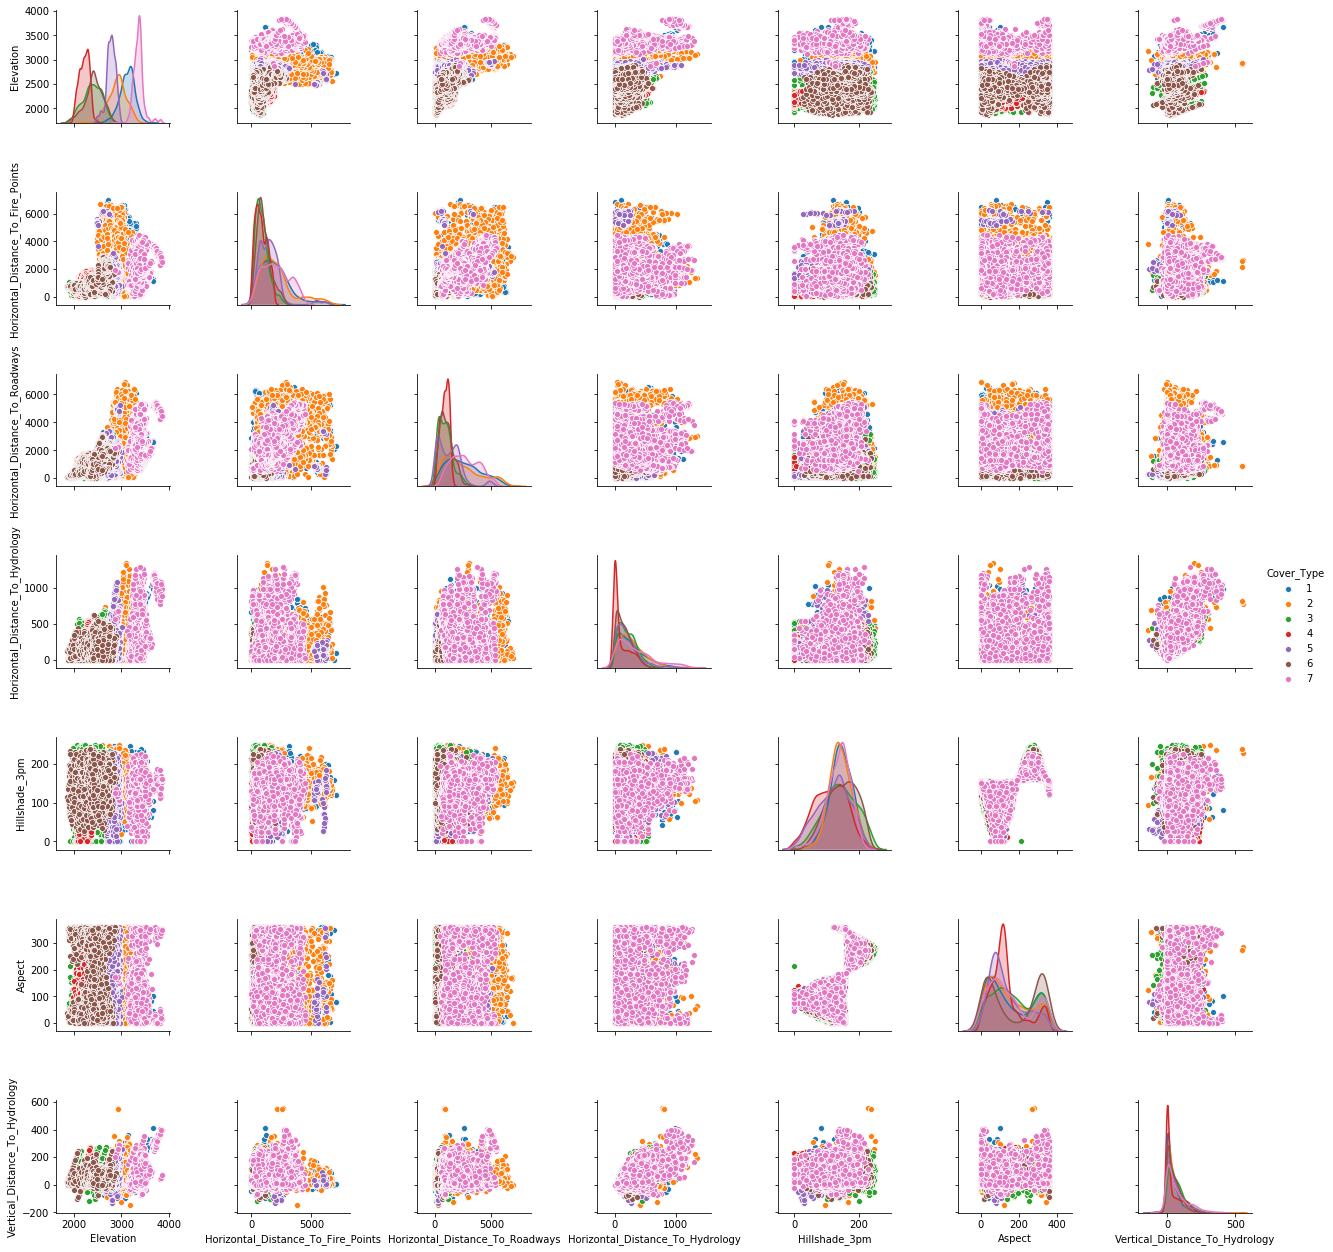

In [70]:
# Plot pairplot between cover type and important variables (based off the RF regressor ranking)
sns.pairplot(train_df, hue='Cover_Type', vars=["Elevation",
                                               "Horizontal_Distance_To_Fire_Points",
                                               "Horizontal_Distance_To_Roadways",
                                               "Horizontal_Distance_To_Hydrology",
                                               "Hillshade_3pm",
                                               "Aspect",
                                               "Vertical_Distance_To_Hydrology"])

> - **Elevation** and **Aspect** show certain degree of class separation.
- The following pair of variables show good class separation: 
    - **Elevation** paired with **Vertical_Distance_To_Hydrology**
    - **Elevation** paired with **Aspect**
    - **Elevation** paired with **Hillshade_3pm**

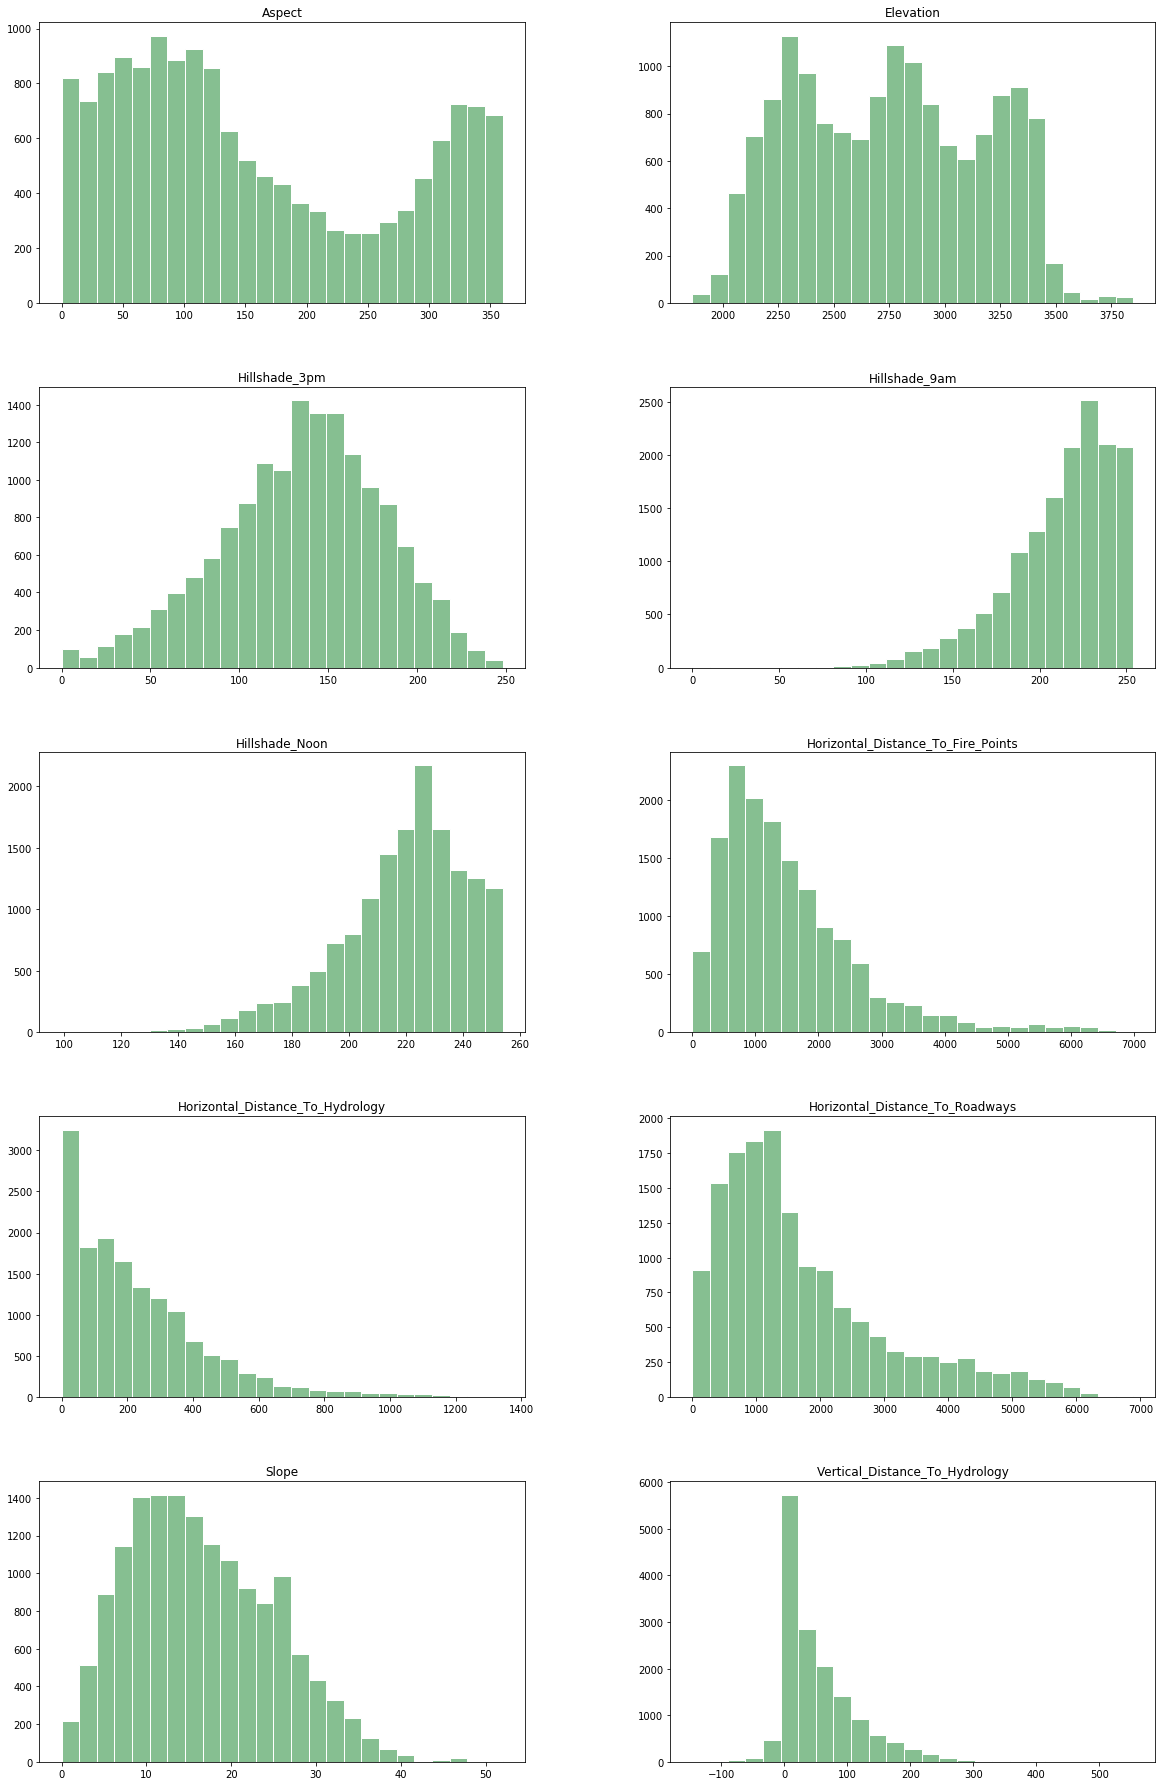

In [36]:
# Plot histogram of each continuous variable to see if can categorize certain variables
train_df_cont.iloc[:,:10].hist(bins=25, grid=False, color='#86bf91', edgecolor='white', 
                               layout=(5,2), figsize=(20,32))
plt.show()


> From above histograms, we could categorize the following variables:
- **Aspect**: group 1 = [0, 250], group 2 = [250,max]
- **Elevation**: group 1 = [0, 2600], group 2 = [2600, 3100], and group 3 = [3100,max]

In [104]:
### Begin Feature Engineering
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:54]
train_df_cover = train_df.iloc[:,54]

# 1. Remove Soil_Type7 and Soil_Type15
train_df_disc_noLabel_1 = train_df_disc_noLabel.drop(['Soil_Type7', 'Soil_Type15'], axis = 1)

# 2. Add two new categorical variables for aspect and elevation to train_df_disc_noLabel_1
labels_aspect = [1, 2]
train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 250, 360], 
                                               labels=labels_aspect, include_lowest=True)

labels_elevation = [1, 2, 3]
train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3100, 3900], 
                                                  labels=labels_elevation, include_lowest=True)


# 4. Concatenate df from step 2, df from step 3, and train_df_cover to generate new df for algo
train_df_engineered = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel_1, train_df_cover], axis = 1)

display(train_df_engineered.head())


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Aspect_Group,Elevation_Group,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [105]:
# train_df_engineered.hist(column='Aspect_Group', grid=False, color='#86bf91')

print(train_df_engineered.groupby('Aspect_Group').size())

print(train_df_engineered.groupby('Elevation_Group').size())

Aspect_Group
1    11141
2     3979
dtype: int64
Elevation_Group
1    5982
2    5328
3    3810
dtype: int64


In [106]:
print(train_df_engineered['Cover_Type'].describe())
print(train_df_engineered.groupby('Cover_Type').size())

count    15120.000000
mean         4.000000
std          2.000066
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max          7.000000
Name: Cover_Type, dtype: float64
Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64


In [107]:
my_data = train_df_engineered.values
train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np(my_data)

print(train_data[:3,:])
print(train_labels[:3])
print(train_data.shape)
print(train_labels.shape)

[[2354 310 25 342 164 1357 143 213 206 466 2 1 0 0 0 1 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2489 207 29 212 63 1986 188 251 182 134 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2263 111 25 150 69 914 253 204 63 1383 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[2 2 3]
(9071, 54)
(9071,)


In [108]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_data, train_labels)

print('Accuracy (a random forest):', rfc.score(dev_data, dev_labels))

Accuracy (a random forest): 0.8488756613756614


In [109]:
seed = 0
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", min_samples_split=15, random_state=seed)
model3 = BaggingClassifier(base_estimator=dt, random_state=seed)
model3.fit(train_data, train_labels)
model3_pred = model3.predict(dev_data)
model3_score = accuracy_score(dev_labels, model3_pred)

print("DecisionTreeClassifier as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model3_score)

DecisionTreeClassifier as Base Model for Bagging:
----------------------------------------------------------------------
Accuracy score: 0.8201058201058201


In [110]:
seed = 0
clf = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
model4 = BaggingClassifier(base_estimator=clf, random_state=seed)
model4.fit(train_data, train_labels)
model4_pred = model4.predict(dev_data)
model4_score = accuracy_score(dev_labels, model4_pred)

print("SVM as Base Model for Bagging, use un-normalized train data:")
print("-"*70)
print("Accuracy score:", model4_score)

SVM as Base Model for Bagging, use un-normalized train data:
----------------------------------------------------------------------
Accuracy score: 0.845568783068783


In [111]:
seed = 0
lr = LogisticRegression(C=0.5, penalty='l2', solver='liblinear', multi_class='auto')
model1 = BaggingClassifier(base_estimator=lr, random_state=seed)
model1.fit(train_data, train_labels)
model1_pred = model1.predict(dev_data)
model1_score = accuracy_score(dev_labels, model1_pred)

print("Logistic Regression as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model1_score)

Logistic Regression as Base Model for Bagging:
----------------------------------------------------------------------
Accuracy score: 0.6769179894179894


In [112]:
seed = 0
knn = KNeighborsClassifier()
model2 = BaggingClassifier(base_estimator=knn, random_state=seed)
model2.fit(train_data, train_labels)
model2_pred = model2.predict(dev_data)
model2_score = accuracy_score(dev_labels, model2_pred)

print("KNeighborsClassifier as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model2_score)

KNeighborsClassifier as Base Model for Bagging:
----------------------------------------------------------------------
Accuracy score: 0.7896825396825397


#### <font color = red> Feature Engineering - Round 2 by Chloe</font>
- <font color = red>Feature engineering: Change aspect to within 180 degree; add "highwater" indicator</font>
- <font color = red>Re-run algo --> See **minor improvement** in accuracy</font>

In [113]:
def shift_degree(x):
    '''
    A function to shift Aspect 180 degree.
    '''
    if x > 180:
        return x-180
    else:
        return x+180


In [120]:
### Begin Feature Engineering Round 2
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:54]
train_df_cover = train_df.iloc[:,54]

# 1. Remove Soil_Type7 and Soil_Type15
train_df_disc_noLabel_1 = train_df_disc_noLabel.drop(['Soil_Type7', 'Soil_Type15'], axis = 1)

# 2. Add two new categorical variables for aspect and elevation to train_df_disc_noLabel_1
labels_aspect = [1, 2]
train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 250, 360], 
                                               labels=labels_aspect, include_lowest=True)

labels_elevation = [1, 2, 3]
train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3100, 3900], 
                                                  labels=labels_elevation, include_lowest=True)

# 3. Add one new categorical variable for aspect to shift it 180 degrees
# train_df_cont_noLabel['Aspect2'] = train_df_cont_noLabel.Aspect.map(shift_degree)

# 4. Add one new binary variable to indicate whether Vertical_Distance_To_Hydrology < 0 
train_df_cont_noLabel['Highwater'] = train_df_cont_noLabel.Vertical_Distance_To_Hydrology < 0

# 5. Concatenate df from step through step 4, and train_df_cover to generate new df for algo
train_df_engineered2 = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel_1, train_df_cover], axis = 1)

display(train_df_engineered2.head())
print(train_df_engineered2.shape)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Aspect_Group,Elevation_Group,Highwater,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,1,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,1,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,2,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,2,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,1,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


(15120, 56)


In [121]:
my_data = train_df_engineered2.values
train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np(my_data)

print(train_data[:3,:])
print(train_labels[:3])
print(train_data.shape)
print(train_labels.shape)

[[2354 310 25 342 164 1357 143 213 206 466 2 1 False 0 0 0 1 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2489 207 29 212 63 1986 188 251 182 134 1 1 False 0 0 1 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2263 111 25 150 69 914 253 204 63 1383 1 1 False 0 0 0 1 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[2 2 3]
(9071, 55)
(9071,)


In [122]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_data, train_labels)

print('Accuracy (a random forest):', rfc.score(dev_data, dev_labels))

Accuracy (a random forest): 0.8485449735449735


In [123]:
seed = 0
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", min_samples_split=15, random_state=seed)
model3 = BaggingClassifier(base_estimator=dt, random_state=seed)
model3.fit(train_data, train_labels)
model3_pred = model3.predict(dev_data)
model3_score = accuracy_score(dev_labels, model3_pred)

print("DecisionTreeClassifier as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model3_score)

DecisionTreeClassifier as Base Model for Bagging:
----------------------------------------------------------------------
Accuracy score: 0.8220899470899471


In [124]:
seed = 0
clf = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
model4 = BaggingClassifier(base_estimator=clf, random_state=seed)
model4.fit(train_data, train_labels)
model4_pred = model4.predict(dev_data)
model4_score = accuracy_score(dev_labels, model4_pred)

print("SVM as Base Model for Bagging, use un-normalized train data:")
print("-"*70)
print("Accuracy score:", model4_score)

SVM as Base Model for Bagging, use un-normalized train data:
----------------------------------------------------------------------
Accuracy score: 0.8449074074074074


In [125]:
seed = 0
lr = LogisticRegression(C=0.5, penalty='l2', solver='liblinear', multi_class='auto')
model1 = BaggingClassifier(base_estimator=lr, random_state=seed)
model1.fit(train_data, train_labels)
model1_pred = model1.predict(dev_data)
model1_score = accuracy_score(dev_labels, model1_pred)

print("Logistic Regression as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model1_score)

Logistic Regression as Base Model for Bagging:
----------------------------------------------------------------------
Accuracy score: 0.6772486772486772


=====================================================================================================================

## 5. Sensible Methods and Error Analysis

### <font color=blue> 5.1 k-nearest neighbor classifier </font>

### *Adam*

#### Function to score KNeighborsClassifier and GaussianNB results

In [ ]:
# Curtis: change train_df1 to train_raw_df.values

def score_fn(classifier, feat_eng = train_raw_df.values):
    '''Takes classifier function and feature engineering level as argument and returns score.'''   
    train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np(feat_eng)
    cls = classifier
    cls.fit(train_data, train_labels)
    cls_pred = cls.predict(dev_data)
#     print(train_data)

    return cls.score(dev_data, dev_labels)

#### Simple implementation of KNeighborsClassifier using default hyperparameters.  Feature Enginering Level1 

In [ ]:
#Default knn parameters: 
#(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
#metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]

print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df1.values),4))

#### Simple implementation of KNeighborsClassifier using default hyperparameters. Feature Enginering Level2

In [ ]:
#Default knn parameters: 
#(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, 
#p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]

print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df2.values),4))

#### Simple implementation of KNeighborsClassifier using default hyperparameters. Feature Enginering Level3

In [ ]:
#Default knn parameters: 
#(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, 
#p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]
print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df3.values),4))

=====================================================================================================================

### <font color=blue> 5.2 Naive Bayes classifier </font>

### *Adam*-GaussianNB

In [ ]:
print("Level 1")
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df1),4))
print("Level 2")
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df2),4))
print("Level 3")
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df3),4))

### *Curtis*-GaussianNB

In [ ]:
print(score_fn(classifier = GaussianNB()))

In [ ]:
clfGNB = GaussianNB()
clfGNB.fit(train_data, train_labels)
dev_predGNB = clfGNB.predict(dev_data)
pred_accuGNB = accuracy_score(dev_labels, dev_predGNB)
print("GNB_score: %0.4f" %pred_accuGNB)

=====================================================================================================================

### <font color=blue> 5.3 Random forest and decision tree classifier</font>

### *Erik*

In [43]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(train_data, train_labels)

print('Accuracy (a decision tree):', dt.score(dev_data, dev_labels))

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_data, train_labels)

print('Accuracy (a random forest):', rfc.score(dev_data, dev_labels))

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

abc.fit(train_data, train_labels)
print('Accuracy (adaboost with decision trees):', abc.score(dev_data, dev_labels))

Accuracy (a decision tree): 0.7880291005291006
Accuracy (a random forest): 0.8511904761904762
Accuracy (adaboost with decision trees): 0.4044312169312169


### *Adam*

In [ ]:
#Random Forest Regressor for Feature Engineering Round1
train_data, dev_data, train_labels, dev_labels = data_to_np(train_df1)
names = train_df1.columns.values
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

In [ ]:
#Random Forest Regressor for Feature Engineering Round2
train_data, dev_data, train_labels, dev_labels = data_to_np(train_df2)
names = train_df2.columns.values
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

=====================================================================================================================

### <font color=blue> 5.4 Logistic Regression classifier</font>

### *Chloe*

In [79]:
# Train a default Logistic Regression model
my_data = train_raw_df.values
train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np(my_data)
model = LogisticRegression()  
model.fit(train_data, train_labels)
model_preds = model.predict(dev_data)
model_score = metrics.f1_score(dev_labels, model_preds, average='weighted')
print("F1 score:", model_score)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


F1 score: 0.6566260512232008


In [80]:
# Train a Logistic Regression model with liblinear solver
model1 = LogisticRegression(solver='liblinear', multi_class='auto')  
model1.fit(train_data, train_labels)
model1_preds = model1.predict(dev_data)
model1_score = metrics.f1_score(dev_labels, model1_preds, average='weighted')
print("F1 score of liblinear solver:", model1_score)

F1 score of liblinear solver: 0.6566260512232008


In [7]:
# Train a Logistic Regression model with liblinear solver, penalty='l1'
model3 = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1')  
model3.fit(train_data, train_labels)
model3_preds = model3.predict(dev_data)
model3_score = metrics.f1_score(dev_labels, model3_preds, average='weighted')
print("F1 score of liblinear solver, L1 penalty:", model1_score)

F1 score of liblinear solver, L1 penalty: 0.6625701086662769


In [8]:
# Experiment with different C
c_values = [0.001, 0.01, 0.03, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0, 2.0, 10.0]

for i in c_values:
    model = LogisticRegression(C=i, penalty='l2', solver='liblinear', multi_class='auto')
    model.fit(train_data, train_labels)
    model_preds = model.predict(dev_data)

    print("F1 score of model with C =", i, "is", 
          metrics.f1_score(dev_labels, model_preds, average='weighted'))

F1 score of model with C = 0.001 is 0.5963400266293629
F1 score of model with C = 0.01 is 0.6445729274037364
F1 score of model with C = 0.03 is 0.6603214451772921
F1 score of model with C = 0.1 is 0.660321295587967
F1 score of model with C = 0.2 is 0.6708253324676877
F1 score of model with C = 0.3 is 0.6732499397368833
F1 score of model with C = 0.5 is 0.6742600340649783
F1 score of model with C = 0.7 is 0.6683042679312546
F1 score of model with C = 0.8 is 0.6597936170825905
F1 score of model with C = 1.0 is 0.6625701086662769
F1 score of model with C = 2.0 is 0.6783013728774732
F1 score of model with C = 10.0 is 0.6770908808685994


In [ ]:
# Use GridSearchCV to xperiment with different C
c_values = {'C': np.arange(0.1, 2.0 ,0.1)}
grid = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='auto'), param_grid=c_values, cv=5)
grid.fit(train_data, train_labels)
print('Optimal C parameter:', grid.best_params_)

best_logit = LogisticRegression(C=grid.best_params_['C'])
best_logit.fit(train_data, train_labels)
best_predict = best_logit.predict(dev_data)
best_score = metrics.f1_score(dev_labels, best_predict, average='weighted')
print("F1 score:", best_score)

=====================================================================================================================

### <font color=blue> 5.5 Support-vector machine classifier</font>

### *Curtis*

In [33]:
# add by Curtis

train_data_norm, dev_data_norm, test_data_norm, train_labels, dev_labels, test_labels\
= data_to_np(train_raw_df_norm.values)

In [34]:
### GridSearchCV

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000], 
#               'decision_function_shape': ('ovo', 'ovr'), 'gamma': ('auto', 'scale')}

parameters = {'C':[1, 10, 100, 1000], 'kernel':('linear', 'rbf')}
clf = svm.SVC(gamma = 'scale')
svc_all = GridSearchCV(clf, parameters, cv=5)
svc_all.fit(train_data_norm, train_labels)
dev_pred = svc_all.predict(dev_data_norm)
pred_accu = accuracy_score(dev_labels, dev_pred)
print(svc_all.cv_results_)
print("Highest accuary score: %0.4f" %pred_accu)

{'mean_fit_time': array([1.51599689, 1.85587082, 1.96390328, 1.63644209, 3.87123442,
       1.66286855, 8.51354494, 1.69163961]), 'std_fit_time': array([0.04483441, 0.01407472, 0.05355496, 0.02395128, 0.21856933,
       0.10473907, 0.56280522, 0.01312446]), 'mean_score_time': array([0.4348537 , 0.55650897, 0.39938889, 0.52186899, 0.39890437,
       0.52743263, 0.3792244 , 0.45839734]), 'std_score_time': array([0.04356157, 0.00349238, 0.00519266, 0.00528558, 0.02651361,
       0.02641697, 0.00273879, 0.00292476]), 'param_C': masked_array(data=[1, 1, 10, 10, 100, 100, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf', 'linear', 'rbf',
                   'linear', 'rbf'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}

In [35]:
### Single model

clf = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
clf.fit(train_data_norm, train_labels)
dev_pred = clf.predict(dev_data_norm)
pred_accu = accuracy_score(dev_labels, dev_pred)
print("SVM accuary score: %0.4f" %pred_accu)


SVM accuary score: 0.7381


In [36]:
### only with continuous variables

clf_cont = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
clf_cont.fit(train_data_norm[:, 0:10], train_labels)
dev_pred_cont = clf_cont.predict(dev_data_norm[:, 0:10])
pred_accu_cont = accuracy_score(dev_labels, dev_pred_cont)
print("SVM accuary score (only continuous variables): %0.4f" %pred_accu_cont)

SVM accuary score (only continuous variables): 0.7017


In [37]:
### only discrete variables

clf_disc = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
clf_disc.fit(train_data_norm[:, 10:], train_labels)
dev_pred_disc = clf_disc.predict(dev_data_norm[:, 10:])
pred_accu_cont = accuracy_score(dev_labels, dev_pred_disc)
print("SVM accuary score (only discrete variables): %0.4f" %pred_accu_cont)

SVM accuary score (only discrete variables): 0.6032


=====================================================================================================================

### <font color=red> 5.6 Bagging and Cross Validations - Added since baseline </font>

### <font color = red> *Chloe* - Updated since baseline </font>

In [44]:
seed = 0
lr = LogisticRegression(C=0.5, penalty='l2', solver='liblinear', multi_class='auto')
model1 = BaggingClassifier(base_estimator=lr, random_state=seed)
model1.fit(train_data, train_labels)
model1_pred = model1.predict(dev_data)
model1_score = accuracy_score(dev_labels, model1_pred)

print("Logistic Regression as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model1_score)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression as Base Model for Bagging:
----------------------------------------------------------------------
F1 score: 0.6772486772486772


In [45]:
seed = 0
knn = KNeighborsClassifier()
model2 = BaggingClassifier(base_estimator=knn, random_state=seed)
model2.fit(train_data, train_labels)
model2_pred = model2.predict(dev_data)
model2_score = accuracy_score(dev_labels, model2_pred)

print("KNeighborsClassifier as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model2_score)

KNeighborsClassifier as Base Model for Bagging:
----------------------------------------------------------------------
Accuracy score: 0.7896825396825397


In [46]:
seed = 0
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", min_samples_split=15, random_state=seed)
model3 = BaggingClassifier(base_estimator=dt, random_state=seed)
model3.fit(train_data, train_labels)
model3_pred = model3.predict(dev_data)
model3_score = accuracy_score(dev_labels, model3_pred)

print("DecisionTreeClassifier as Base Model for Bagging:")
print("-"*70)
print("Accuracy score:", model3_score)

DecisionTreeClassifier as Base Model for Bagging:
----------------------------------------------------------------------
Accuracy score: 0.8194444444444444


In [28]:
seed = 0
kf = model_selection.KFold(n_splits=10, random_state=seed)
dt = DecisionTreeClassifier(random_state=seed)
model3 = BaggingClassifier(base_estimator=dt, random_state=seed)
cv_results = model_selection.cross_val_score(model3, train_data, train_labels, scoring='f1_weighted', cv=kf)

print("DecisionTreeClassifier as Base Model for Bagging:")
print("-"*70)
print("F1 score with cross validation:", cv_results.mean())

DecisionTreeClassifier as Base Model for Bagging:
----------------------------------------------------------------------
F1 score with cross validation: 0.8078708901704343


In [47]:
seed = 0
clf = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
model4 = BaggingClassifier(base_estimator=clf, random_state=seed)
model4.fit(train_data, train_labels)
model4_pred = model4.predict(dev_data)
model4_score = accuracy_score(dev_labels, model4_pred)

print("SVM as Base Model for Bagging, use un-normalized train data:")
print("-"*70)
print("Accuracy score:", model4_score)

SVM as Base Model for Bagging, use un-normalized train data:
----------------------------------------------------------------------
Accuracy score: 0.845568783068783


In [48]:
seed = 0
clf = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
model5 = BaggingClassifier(base_estimator=clf, random_state=seed)
model5.fit(train_data_norm, train_labels)
model5_pred = model5.predict(dev_data_norm)
model5_score = accuracy_score(dev_labels, model5_pred)

print("SVM as Base Model for Bagging, using normalized train data:")
print("-"*70)
print("Accuracy score:", model5_score)

SVM as Base Model for Bagging, using normalized train data:
----------------------------------------------------------------------
Accuracy score: 0.7337962962962963


=====================================================================================================================

## 6. Model Comparions, Findings and Conclusions

### *Erik*

### General
* The most direct correlations with cover type come from some soil type
* we have all zero for soil type 7 and 15, smoothing is required for NB if we want to keep the features
* Make sure ID is not used in training 
* The feature space is not sparse because it's mostly binary data and there's only 55 features
* Use cross-validation to optimize hyper-parameter
* The mean of soil_type features are all significantly below 0.5. Mostly below 0.1. Therefore, this means most cover_types have many soil_type = 0. We can try summing the soil_type features and maybe some pattern will emerge (some cover type are corresponding to diverse soil types and that's a good supplement feature to use)

#### KNN
* we will need to standardize the features if we want to make the features roughly contributes equally to the predictions

#### Naive Bayes
* we will need to binarize the dataset to use bernoulliNB since more than half of our variables are binary
* Conditional Independence:
    * We see that after conditioning on a specific cover type, the correlation increases especially when the features besides cover-types are involved. We need to take out the strongly correlated features before training

#### Decision Tree
* Make sure ID is not used in training
* Watch out for over fitting

#### Logistic Regression
* use one vs all
* some regularization

#### Neural Nets

> Can we use different sets of features for different models

### *Adam*

https://stats.stackexchange.com/questions/169400/naive-bayes-questions-continus-data-negative-data-and-multinomialnb-in-scikit
Why can't negative data be used here?
MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values.

How is scikit-learn handling the continuous data?
If you want to work with bayesian methods use GaussianNb but generally there are a lot of estimators capable of handling continuous data in scikit-learn.

<font color=red>**Plot Probability Calibration curves (for model comparison)** </font>

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py